# Cluster Ask.Cyberinfrastructure By Tags

This notebook will try to do a clustering of AskCI topics based on tags. Generally we will:

 - Make a matrix of shape (number of posts, number of unique tags) that stores which tags correspond to which post. There is a 1 for posts containing a tag, and 0 otherwise. 
 - Use a dimensionality reduction method, like ICA, on the matrix. The number of components is the number of signals and using fit_transform will give us a matrix of shape (n_samples, n_components) corresponding to the mixture of signals. We can then use TSNE to plot these. 

For those not familiar with Discourse terminology, a "topic" is one page of posts by multiple users to answer a question of interest or discuss an idea. In the case of AskCI, we have Question and Answers topics (category Q&A) and Discussion Zone topics.

*unsolicited comment* this is one of the reasons I highly dislike notebooks - I'm literally copy pasting the loading functions from the other notebook. Oy vey.

See the documentation at: <a>https://radimrehurek.com/gensim/index.html</a>

In [1]:
from sklearn.decomposition import FastICA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cluster, metrics
from sklearn.manifold import TSNE
import pandas
import seaborn
import matplotlib.pylab as plt
%matplotlib inline

import json
import os
import re

date_folder = "2019-10-19"
board = "ask.cyberinfrastructure.org"
categories = ["q-a", "Area-for-open-ended-topics-of-interest"]

tags = []
labels = []
meta = {}
seen = []

def read_json(json_file):
    with open(json_file, 'r') as filey:
        content = json.loads(filey.read())
    return content
        
                
# Add metadata for each topic
for category in categories:

    # Metadata includes tags, likes, etc.
    json_path = os.path.join(date_folder, "%s-%s-topics-%s.json" %(board, category, date_folder))
    content = read_json(json_path)

    for details in content:        
        topic_id = details['id']

        # For some reason a few topics returned multiple times
        if topic_id not in seen:
            labels.append(topic_id)
            meta[topic_id] = details
            tags.append(' '.join(details["tags"]))
            seen.append(details['id'])

print(len(tags)) # these are string of tags for each post
print(tags[1])
print(len(meta))
print(len(labels))

179
notebooks jupyter
179
179


In [2]:
# Create count vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tags)

# This also splits the -, which isn't bad because it gives more data
print(vectorizer.get_feature_names()[0:50])

# This is a row for each topic (N=179) and a column (with count) for each tag
print(X.shape)

['administering', 'ai', 'allocations', 'amber', 'analysis', 'anatomy', 'and', 'api', 'arch', 'architecture', 'archiving', 'array', 'aws', 'azure', 'backup', 'bash', 'bioinformatics', 'blackhole', 'carpentry', 'center', 'cephfs', 'cgroups', 'chemistry', 'cleanup', 'cloud', 'cluster', 'communication', 'comparison', 'compiling', 'compliance', 'computational', 'computing', 'connection', 'containers', 'cost', 'cuda', 'cyberinfrastructure', 'data', 'debugging', 'deep', 'dependencies', 'deployment', 'dft', 'dmtcp', 'docker', 'documentation', 'dtn', 'dynamics', 'easybuild', 'encryption']
(179, 187)


In [3]:
# A function to save a plot to file as json to use d3.
# Yes it's terrible, we are using global variables here, hashtag notebooks ug.
def saveJson(X_embeded, output_file):
    data = []
    for i, row in enumerate(X_embedded):
        label = labels[i]
        details = meta[label]
        url = "https://ask.cyberinfrastructure.org/t/%s/%s/" %(details['slug'], label)
        data.append({"x": round(row[0].astype(float), 6),  # from pandas
                     "y": round(row[1].astype(float), 6),  # try to maintain original precision
                     "post_id": label, 
                     "posts_count": details["posts_count"], 
                     "tags": details["tags"],
                     "url": url,
                     "views": details["views"],
                     "like_count": details["like_count"],
                     "title": details["title"]})
    
    with open(output_file, 'w') as filey:
        filey.writelines(json.dumps(data, indent=4))

Generated 1 components: (179, 1)
Generated 2 components: (179, 2)
Generated 3 components: (179, 3)
Generated 4 components: (179, 4)
Generated 5 components: (179, 5)
Generated 6 components: (179, 6)
Generated 7 components: (179, 7)
Generated 8 components: (179, 8)
Generated 9 components: (179, 9)
Generated 10 components: (179, 10)


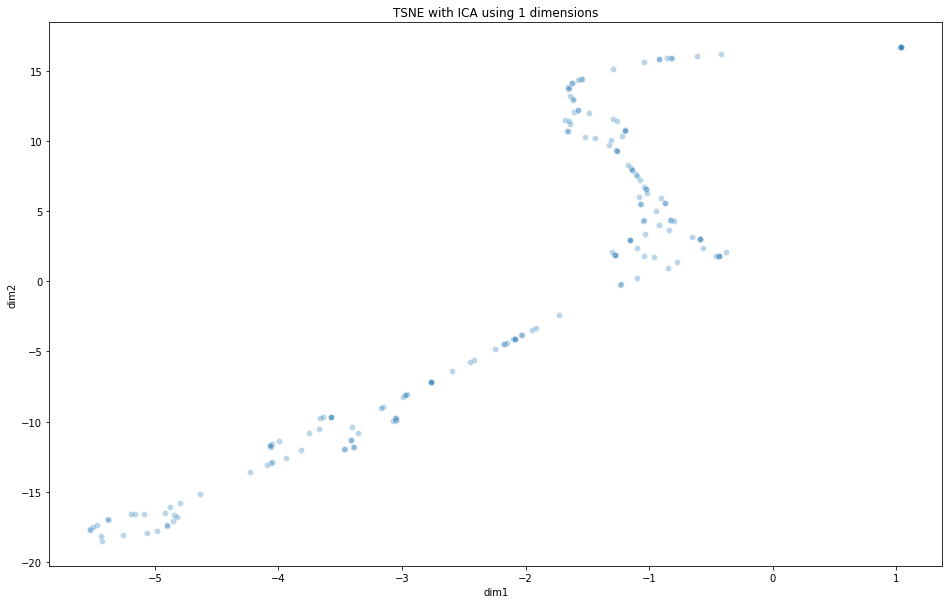

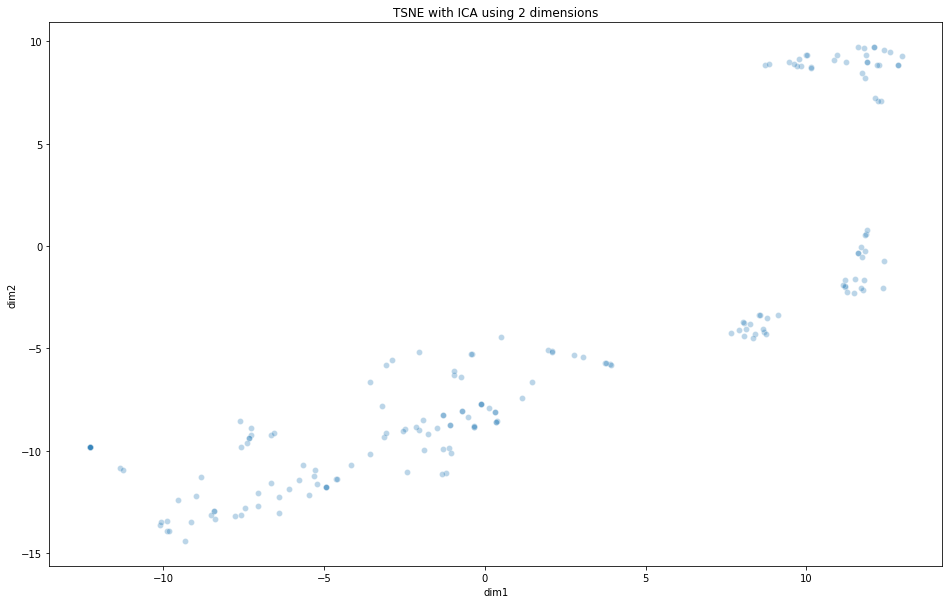

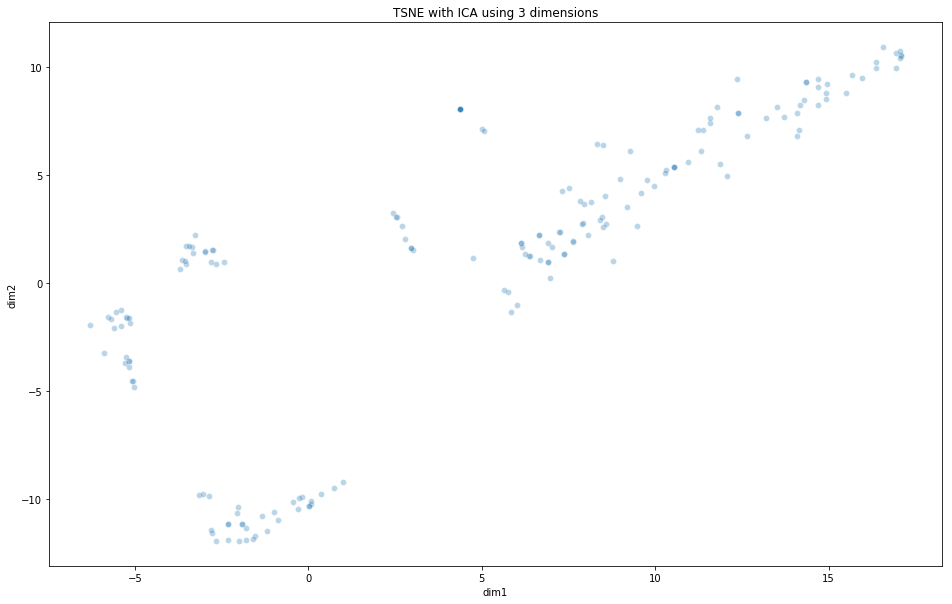

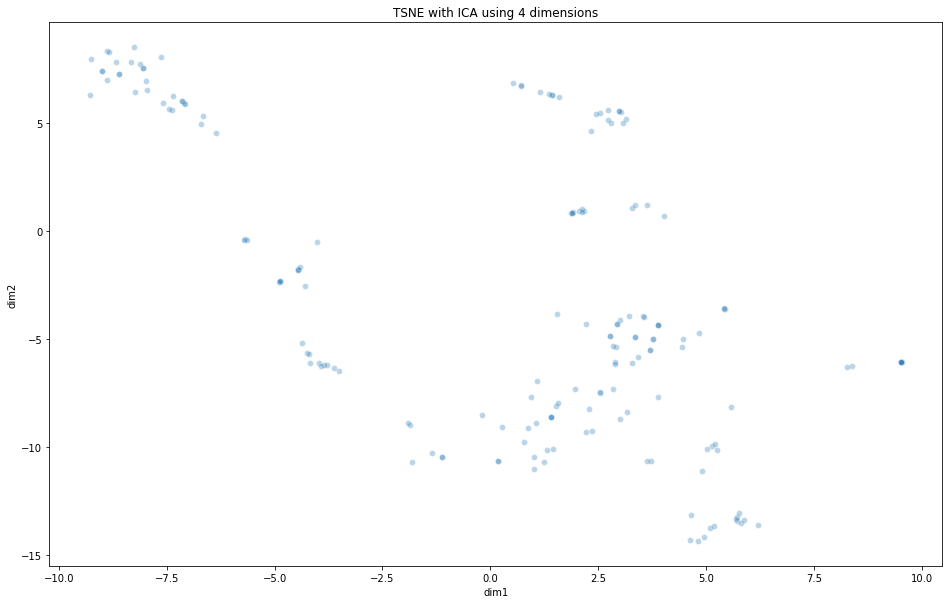

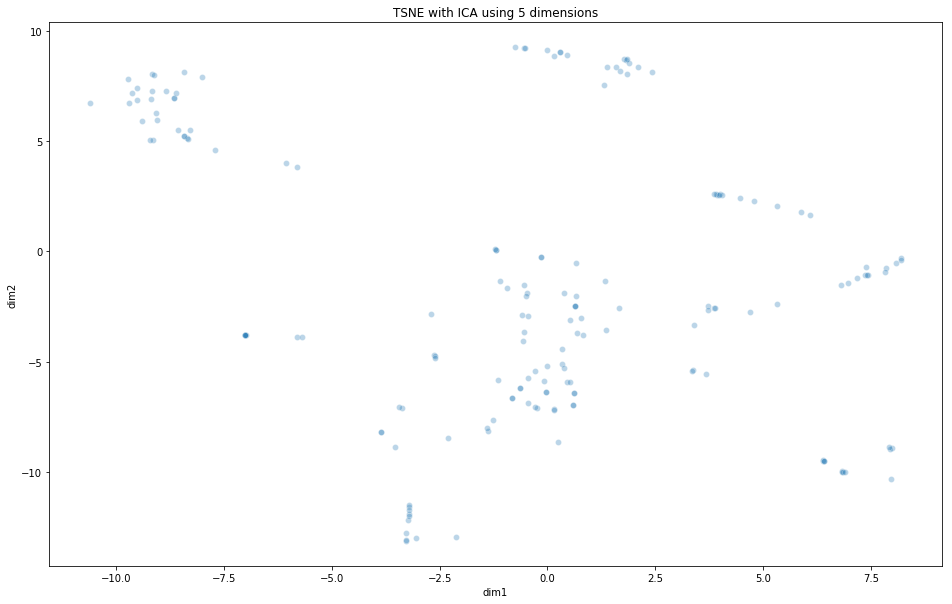

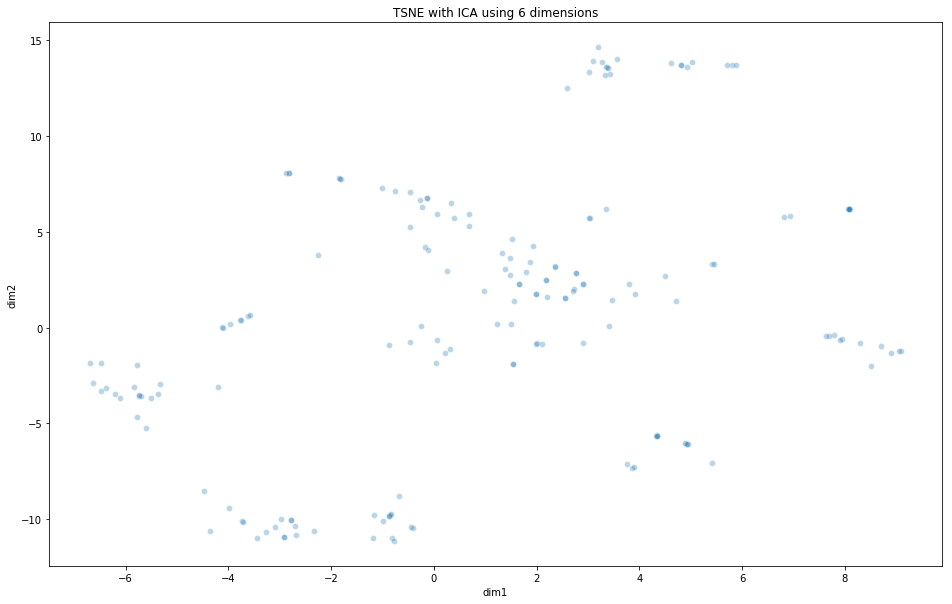

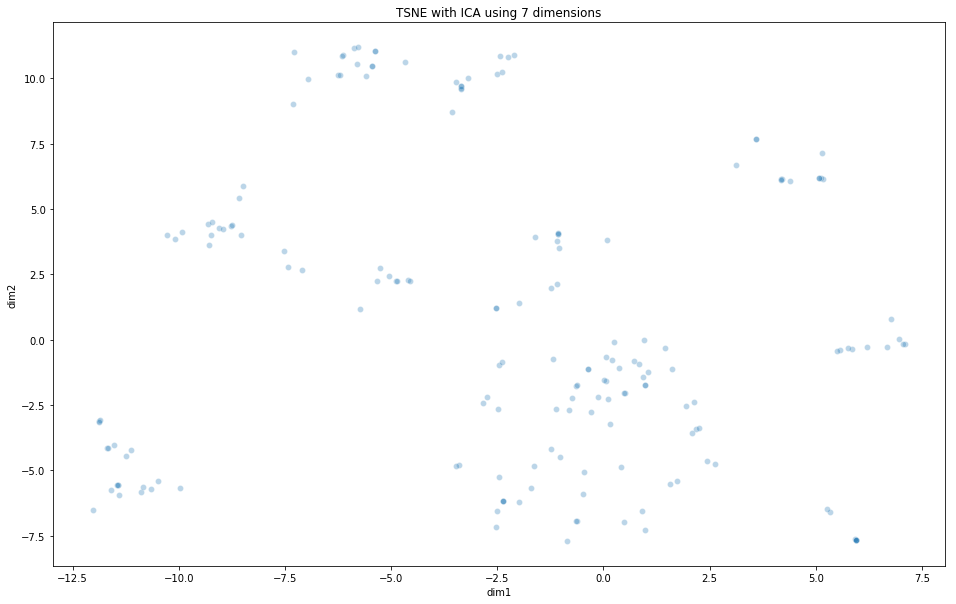

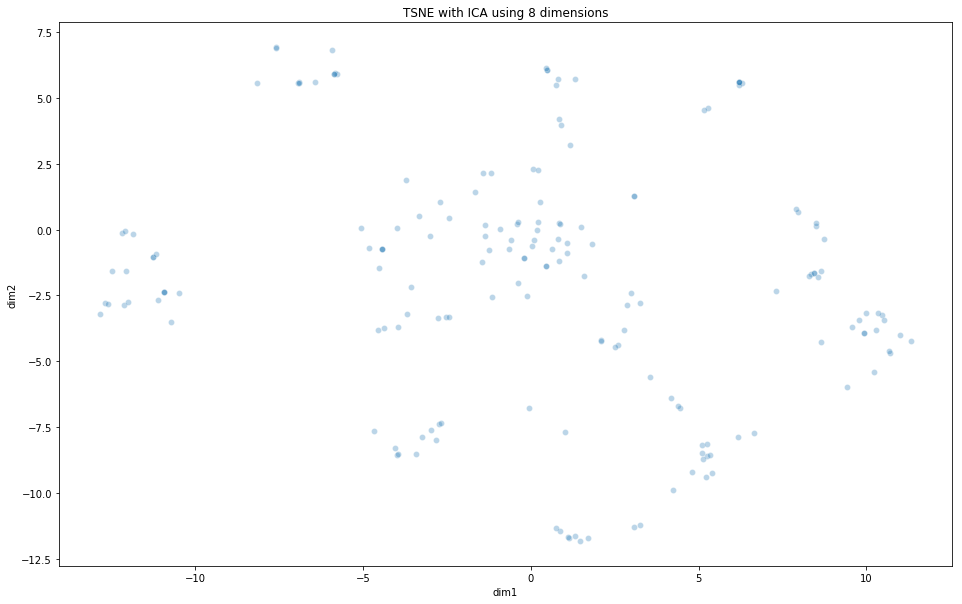

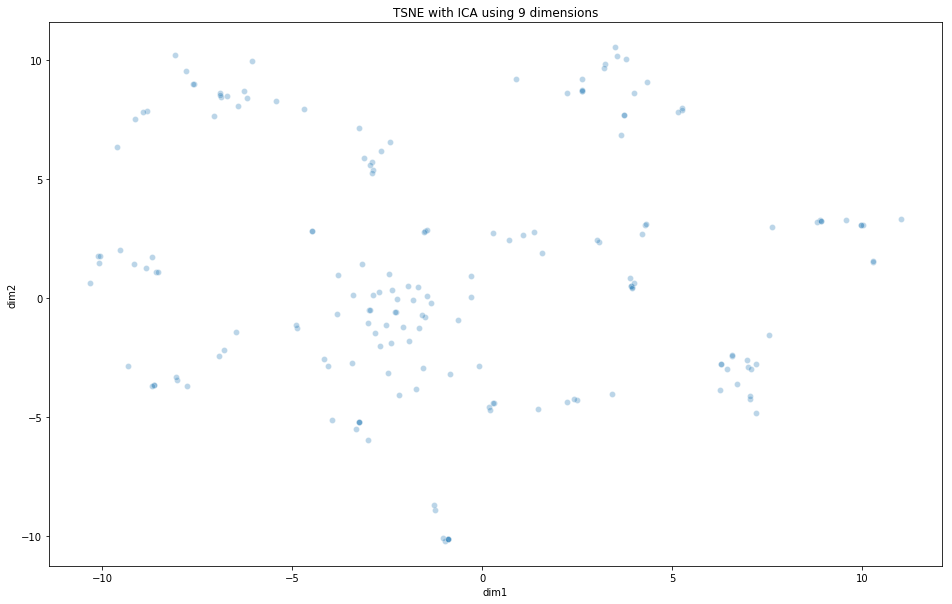

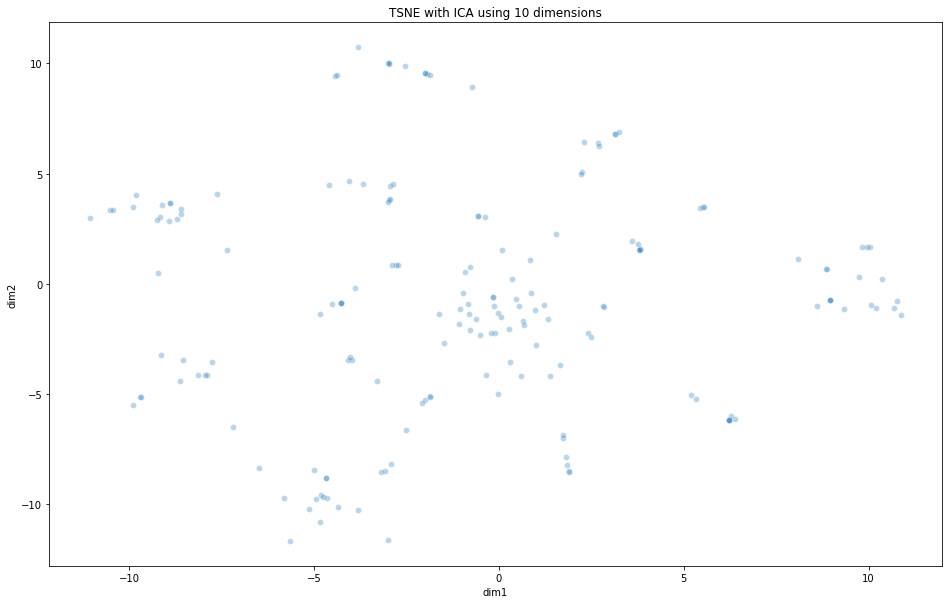

In [4]:
# Dimensionality reduction on the matrix, try tsne for each, save data also
for n_comps in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    transformer = FastICA(n_components=n_comps, random_state=0)
    X_transformed = transformer.fit_transform(X.toarray())
    print("Generated %s components: %s" % (n_comps, X_transformed.shape))
          
    # Plot with TSNE
    X_embedded = TSNE(n_components=2).fit_transform(X_transformed)
    df = pandas.DataFrame(X_embedded)
    df.columns = ['dim1', 'dim2']

    title = "TSNE with ICA using %s dimensions" % n_comps
    plt.figure(figsize=(16,10))
    plot = seaborn.scatterplot(
        x='dim1',
        y='dim2',
        data=df,
        palette=seaborn.color_palette("hls", 10),
        legend="full",
        alpha=0.3
    ).set_title(title)
    
    saveJson(X_embedded, "askci-tags-ica-embeddings-ncomps-%s.json" % n_comps)

In [5]:
# There is some structure!